In [2]:
from IPython.display import display_png
from networkx import draw
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler import CouplingMap, Layout, PassManager
from qiskit.transpiler.passes import (
    SabreLayout, TrivialLayout, SetLayout, FullAncillaAllocation, EnlargeWithAncilla, ApplyLayout, Decompose, SabreSwap
)
from router.sqgm_swap import SQGMSwap
from ag import *


def display_ag(ag) -> None:
    draw(ag)

def display_qc(qc, t="circuit") -> None:
    if t == "dag":
        dag = circuit_to_dag(qc)
        display_png(dag.draw())
    elif t == "circuit":
        display(qc.draw("mpl", style="iqp"))
    else:
        raise ValueError("argument `t` must be either 'dag' or 'circuit'")

# Architecture graphs

The following quantum devices were used throughout the paper:
1. Ourense (5 qubits)
2. Tokyo (20 qubits)
3. Rochester (53 qubits)
4. Sycamore53 (53 qubits)
5. Sycamore54 (54 qubits)

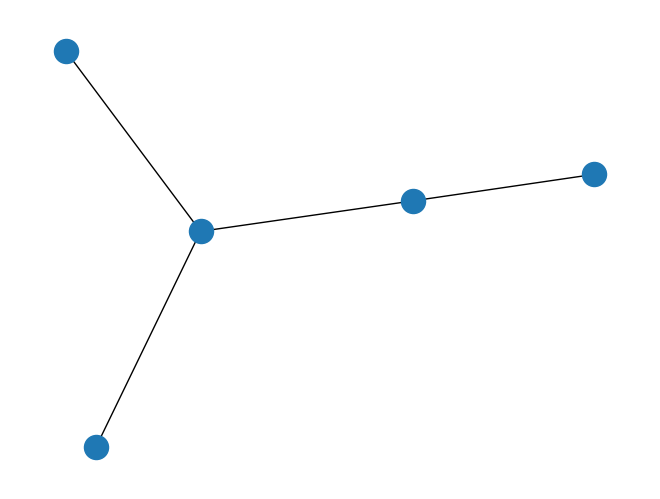

In [4]:
display_ag(ourense())

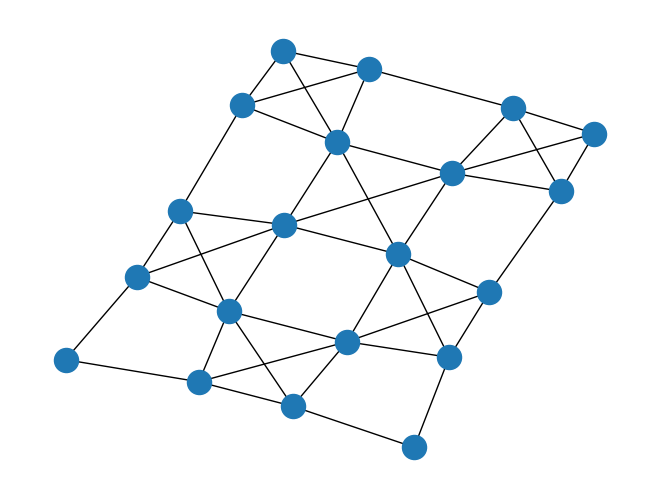

In [5]:
display_ag(tokyo())

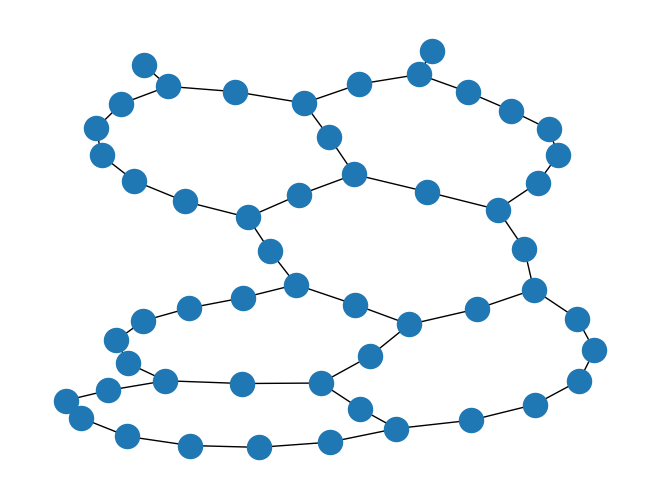

In [20]:
display_ag(rochester())

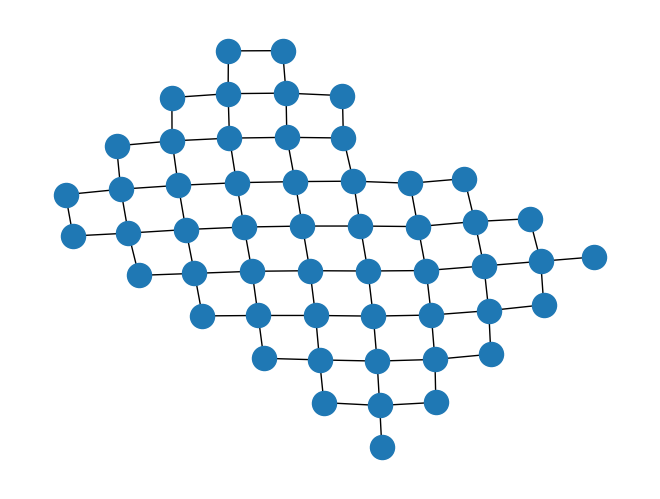

In [7]:
display_ag(sycamore53())

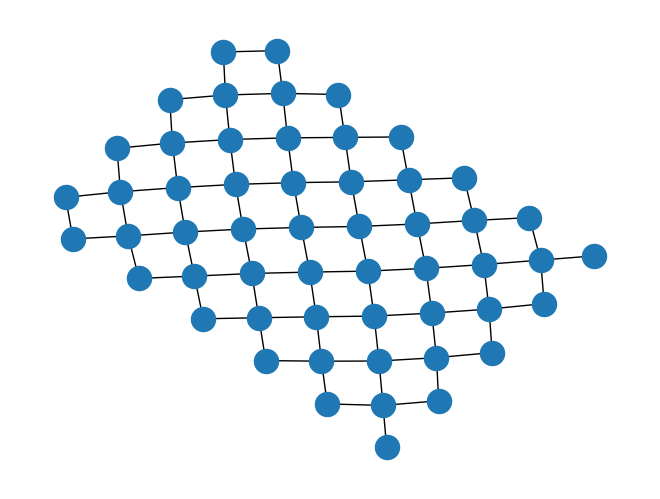

In [8]:
display_ag(sycamore54())

# Verifying `example_4q`

Refer to $\text{Fig. 1}$ in the paper.

1. A logical circuit $C$ with qubits $P := \{p_0, p_1, p_2, p_3\}$. We attempt to transform $C$ such that it is executable on IBM Q Ourense, with qubits $V := \{v_0, v_1, v_2, v_3, v_4\}$.
2. An initial mapping $\pi: P \to V$, under which we have $p_0 \mapsto v_1, p_1 \mapsto v_0, p_2 \mapsto v_2, p_3 \mapsto v_3$.
3. A SABRE transformation (using Qiskit 0.39.4 SabreSwap).
4. A SQGM transformation.

Note that the circuits displayed in (2-4) represent the target backend with the logical circuit *embedded* onto it under $\pi$, i.e., $q_i = v_i, 0 \leq i \leq 4$.

As expected, SQGM reduces the transformation depth from SABRE's **15** to **11**.

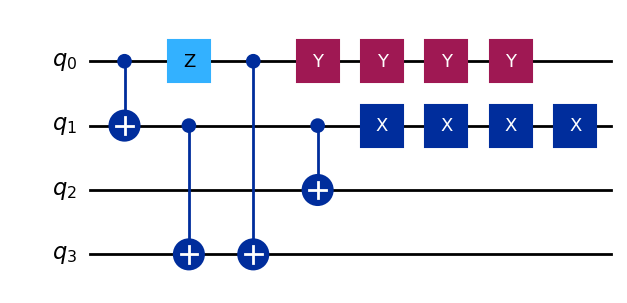

DEPTH: 7


In [18]:
ag = CouplingMap(ourense().edges)
qc = QuantumCircuit.from_qasm_file("benchmark/example_4q/example_4q.qasm")
display_qc(qc)
print(f"DEPTH: {qc.depth()}")

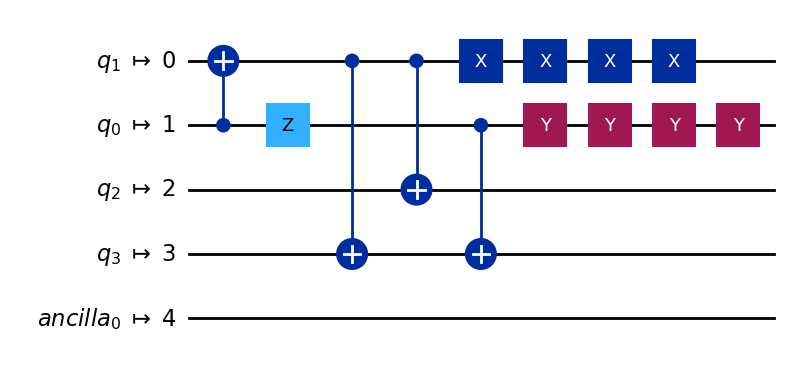

DEPTH: 7


In [19]:
im = Layout({
    qc.qubits[0]: 1,
    qc.qubits[1]: 0,
    qc.qubits[2]: 2,
    qc.qubits[3]: 3
})
init_pm = PassManager([
    SetLayout(im),
    FullAncillaAllocation(ag),
    EnlargeWithAncilla(),
    ApplyLayout()
])
init_qc = init_pm.run(qc)

display_qc(init_qc)
print(f"DEPTH: {qc.depth()}")

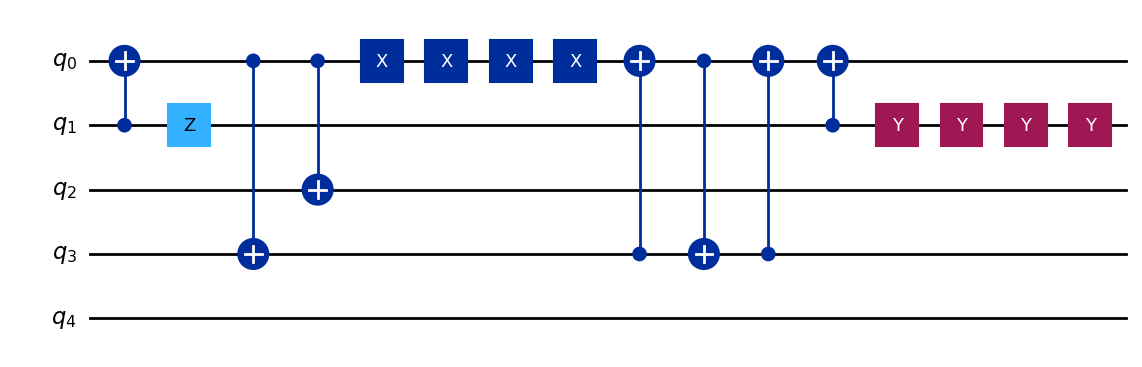

SABRE DEPTH: 15


In [20]:
sabre_pm = PassManager([
    SabreSwap(ag, heuristic="decay"),
    Decompose("swap")
])
sabre_qc = sabre_pm.run(init_qc)

display_qc(sabre_qc)
print(f"SABRE DEPTH: {sabre_qc.depth()}")

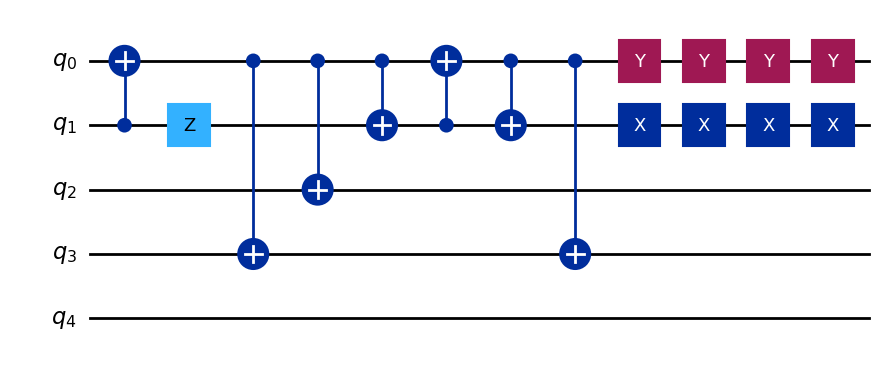

SQGM DEPTH: 11


In [21]:
sqgm_pm = PassManager([
    SQGMSwap(ag, heuristic="decay"),
    Decompose("swap")
])
sqgm_qc = sqgm_pm.run(init_qc)

display_qc(sqgm_qc)
print(f"SQGM DEPTH: {sqgm_qc.depth()}")

# Role of the SQGM heuristic

It is observed that SQGM performs exceptionally better than SABRE on `mqtbench`'s GHZ circuits. Since these circuits only comprise 1 single-qubit gate (H gate), it is unlikely that the superiority is due to SQGM's gate-buffer mechanism. We thus claim that the large performance difference highlights the role of $H_\text{sqgm}$. To see this, let us investigate the circuit below, which is an extension of the 4-qubit GHZ circuit (on a 7-qubit layout) prepended with a series of 6 CNOT gates.

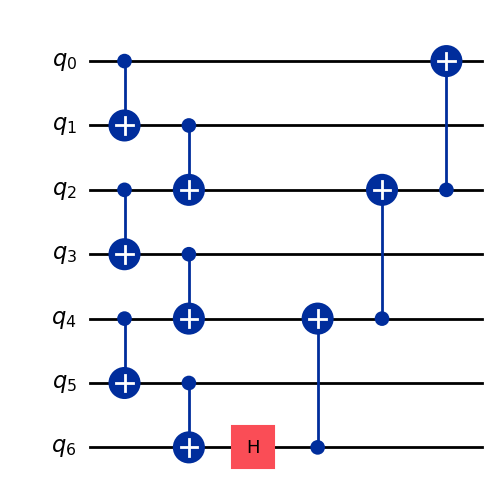

NUM_2QGATES: 9
DEPTH: 6


In [3]:
ag = CouplingMap(line(7).edges)

qc = QuantumCircuit(7)
qc.cx(0,1)
qc.cx(2,3)
qc.cx(4,5)
qc.cx(1,2)
qc.cx(3,4)
qc.cx(5,6)
qc.h(6)
qc.cx(6,4)
qc.cx(4,2)
qc.cx(2,0)

display_qc(qc)
print(f"NUM_2QGATES: {qc.count_ops()['cx']}")
print(f"DEPTH: {qc.depth()}")

Let us now run SABRE and SQGM **50** times and take the best results (i.e., **lowest** depth). On each rep, the same initial mapping, generated by `SabreLayout`, is fed into both routers. As we can see, SABRE's best transformation has depth **12**, compared to SQGM's depth count of **9**. In fact, if we feed into SABRE the same initial mapping which produces the lowest-depth SQGM transformation, SABRE's depth count may rise to **15**.

Looking at the transformed circuits, we can see the role of $H_\text{sqgm}$: it prioritises SWAPs reducing the inbalanced progresses between qubits, consequently leading to more parallel SWAPs being inserted. This phenomenon is amplified as the number of qubits grows. Thus, for 50-and-above-qubit GHZ circuits, SQGM significantly outperforms SABRE.

If one wishes to further convince themselves that the improvement is indeed the work of $H_\text{sqgm}$, try to set `enhance_h` to False when calling `SQGMSwap` below (which forces SQGM to use the original SABRE's heuristic instead) and rerun the experiment: the results of SQGM should become identical to that of SABRE. 

In [110]:
reps = 50
sabre_min_dp = 0
sabre_min_qc = None
sqgm_min_dp = 0
sqgm_min_qc = None

for _ in range(reps):
    
    try:
        mapper = SabreLayout(ag, skip_routing=True)
    except TypeError:
        mapper = SabreLayout(ag)
    init_pm = PassManager([
        mapper,
        FullAncillaAllocation(ag),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ])
    init_qc = init_pm.run(qc)

    sabre_pm = PassManager([
        SabreSwap(ag, heuristic="decay"),
    ])
    sabre_qc = sabre_pm.run(init_qc)
    if not sabre_min_dp or (sabre_qc.depth() < sabre_min_dp):
        sabre_min_dp = sabre_qc.depth()
        sabre_min_qc = sabre_qc

    sqgm_pm = PassManager([
        SQGMSwap(ag, heuristic="decay", enhance_h=True),
    ])
    sqgm_qc = sqgm_pm.run(init_qc)
    if not sqgm_min_dp or (sqgm_qc.depth() < sqgm_min_dp):
        sqgm_min_dp = sqgm_qc.depth()
        sqgm_min_qc = sqgm_qc

sabre_dqc = sabre_min_qc.decompose("swap")
sqgm_dqc = sqgm_min_qc.decompose("swap")

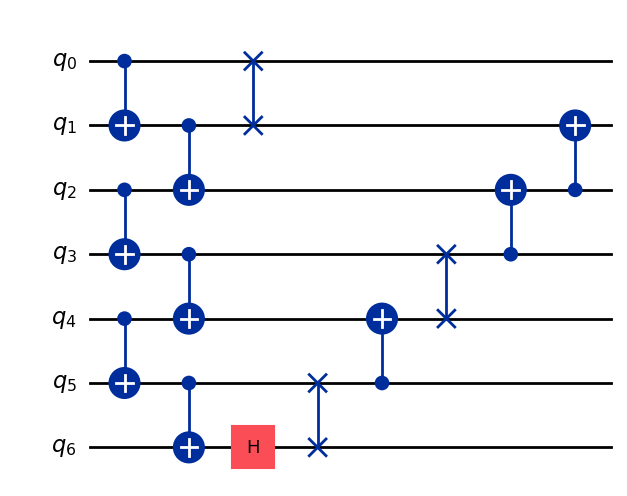

SABRE NUM_2QGATES: 18
SABRE DEPTH: 12


In [111]:
display_qc(sabre_min_qc)
print(f"SABRE NUM_2QGATES: {sabre_dqc.size(lambda ins: len(ins.qubits) > 1)}")
print(f"SABRE DEPTH: {sabre_dqc.depth()}")

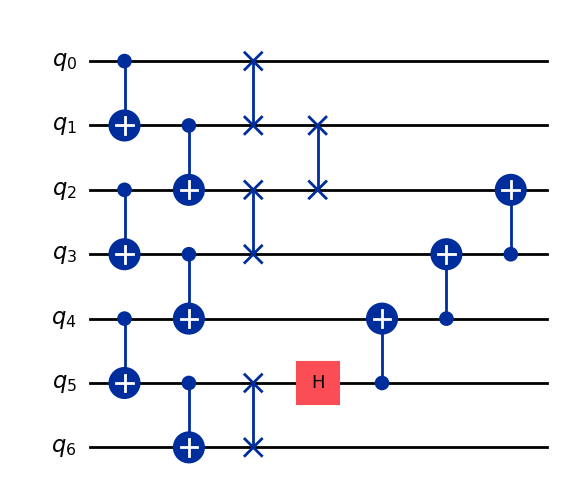

SQGM NUM_2QGATES: 21
SQGM DEPTH: 9


In [112]:
display_qc(sqgm_min_qc)
print(f"SQGM NUM_2QGATES: {sqgm_dqc.size(lambda ins: len(ins.qubits) > 1)}")
print(f"SQGM DEPTH: {sqgm_dqc.depth()}")